# Notebook 4.1 - MobileNet v1

### 1. Setup constants

In [1]:
from constants import *

### 2. Imports and notebook setup

In [2]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [36]:
# Default imports
import os
import seaborn as sn
import re
import glob
import random
import shutil
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pylab as pl
import cv2

# Tensorflow
import tensorflow
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import top_k_categorical_accuracy
from keras.utils.np_utils import to_categorical
# Sklearn
from sklearn.metrics import confusion_matrix

### 3. Create model + Data Augmentation on the fly

#### 3.1 Set version to avoid overwirting previous files

In [4]:
# Set version to avoid overwirting previous files
base_name = 'mobile_net_v'
version = 0
while any([bool(re.match(base_name + str(version), x)) for x in os.listdir('.')]):
    version += 1
print('version', version)

version 2


#### 3.2 Model Constants

In [5]:
# Constants
TRAIN_BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_EPOCHS = 10

num_train_samples = len(glob.glob(os.path.join(TRAIN_PATH, '*', '*.' + IMG_FORMAT)))
train_steps = np.ceil(num_train_samples / TRAIN_BATCH_SIZE)

#### 3.4 Load train image from disk to memory at run time

In [6]:
X_train = []
y_train = []

for cls in DIAGNOSTIC_CLASSES:
    counter = 0
    for img in glob.glob(os.path.join(TRAIN_PATH, cls, '*.' + IMG_FORMAT)):
        counter += 1
        X_train.append(tensorflow.keras.applications.mobilenet.preprocess_input(\
                                                        cv2.resize(plt.imread(img), (IMAGE_SIZE, IMAGE_SIZE))))
    y_train = y_train + [DIAG_2_NUM[cls]] * counter

X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train).reshape(-1, 1))

In [7]:
# # Data flow
# datagen = ImageDataGenerator(preprocessing_function = \
#                              tensorflow.keras.applications.mobilenet.preprocess_input)

# train_flow = datagen.flow_from_directory(train_path,
#                                          target_size=(image_size, image_size),
#                                          batch_size=train_batch_size)

In [8]:
# train_flow.class_indices

#### 3.5 Load validation image to memory

In [9]:
X_val = []
y_val = []

for cls in DIAGNOSTIC_CLASSES:
    counter = 0
    for img in glob.glob(os.path.join(VAL_PATH, cls, '*.' + IMG_FORMAT)):
        counter += 1
        X_val.append(tensorflow.keras.applications.mobilenet.preprocess_input(\
                                                        cv2.resize(plt.imread(img), (IMAGE_SIZE, IMAGE_SIZE))))
    y_val = y_val + [DIAG_2_NUM[cls]] * counter

X_val = np.array(X_val)
y_val = to_categorical(np.array(y_val).reshape(-1, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


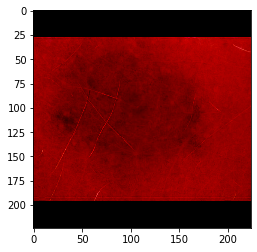

In [10]:
_ = plt.imshow(X_val[1090])

#### 3.3 Transfer Learning MobileNet

In [11]:
# Load MobileNet
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# Set architecture
x = mobile.layers[-6].output

# x = Dropout(0.4)(x)
# x = Dense(1024, activation='tanh')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='tanh')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [14]:
# Leave only the last 11 layers trainable.
# 1 drop + 1 dense: 22, 16, 9
# 2 drop + 2 dense: 11, 18
# 3 drop + 3 dense: 13
# 2 drop + 2 BatchNormalization + 2 dense: 20

for layer in model.layers[:-20]:
    layer.trainable = False

In [15]:
# name, name_scope
# dir(model.layers[-22])
model.layers[-20].name

'conv_pad_12'

In [16]:
# Define Top2 Accuracy
# def top_2_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

#### 3.6 Train Model

In [17]:
checkpoint = ModelCheckpoint(base_name + str(version) + '_{val_acc:.2f}.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=2,
                                   verbose=1, mode='max', min_lr=0.0001, cooldown=2)
                              
callbacks_list = [checkpoint, reduce_lr]

# history = model.fit_generator(train_flow, 
#                               steps_per_epoch=train_steps,
#                               validation_data=(X_val, y_val),
#                               epochs=num_epochs,
#                               verbose=1,
#                               callbacks=callbacks_list)

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=TRAIN_BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val)
                   )

Train on 13156 samples, validate on 1494 samples
Epoch 1/10
13152/13156 [============================>.] - ETA: 0s - loss: 1.1159 - acc: 0.6595
Epoch 00001: val_acc improved from -inf to 0.04485, saving model to mobile_net_v2_0.04.h5
13156/13156 [==============================] - 356s 27ms/sample - loss: 1.1157 - acc: 0.6595 - val_loss: 5.7335 - val_acc: 0.0448
Epoch 2/10
13152/13156 [============================>.] - ETA: 0s - loss: 0.6272 - acc: 0.7797
Epoch 00002: val_acc improved from 0.04485 to 0.67068, saving model to mobile_net_v2_0.67.h5
13156/13156 [==============================] - 354s 27ms/sample - loss: 0.6274 - acc: 0.7797 - val_loss: 2.5691 - val_acc: 0.6707
Epoch 3/10
13152/13156 [============================>.] - ETA: 0s - loss: 0.4560 - acc: 0.8372
Epoch 00003: val_acc did not improve from 0.67068
13156/13156 [==============================] - 356s 27ms/sample - loss: 0.4560 - acc: 0.8372 - val_loss: 2.4889 - val_acc: 0.4163
Epoch 4/10
13152/13156 [===================

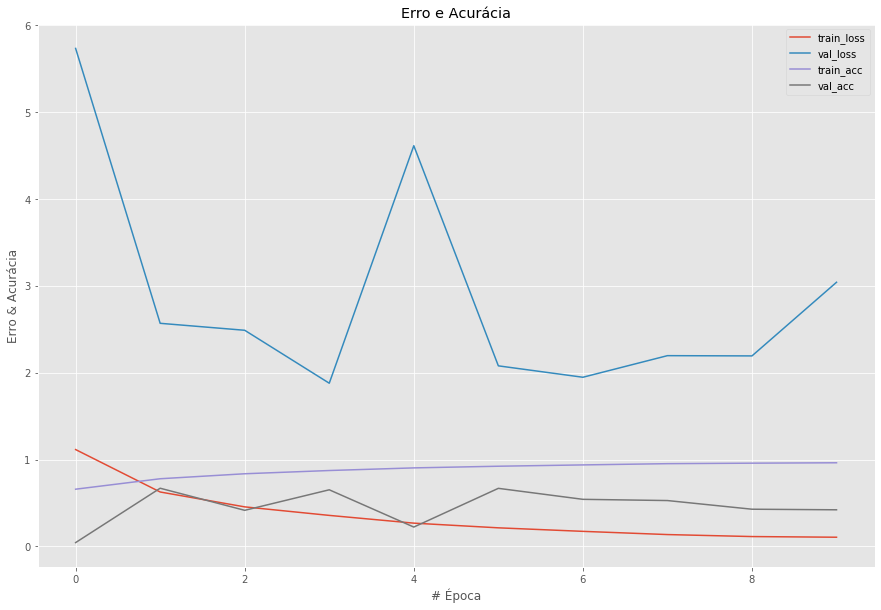

In [19]:
plt.style.use("ggplot")
_ = plt.figure(figsize=(15, 10))
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["acc"], label="train_acc")
_ = plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_acc"], label="val_acc")
_ = plt.title("Erro e Acurácia")
_ = plt.xlabel("# Época")
_ = plt.ylabel("Erro & Acurácia")
_ = plt.legend(loc="upper right")

# plt.savefig(base_name + str(version) + '.png')

### 3.7 Confusion matrix

In [ ]:
probas = model.predict(X_val)
classes = np.argmax(probas, axis=1)

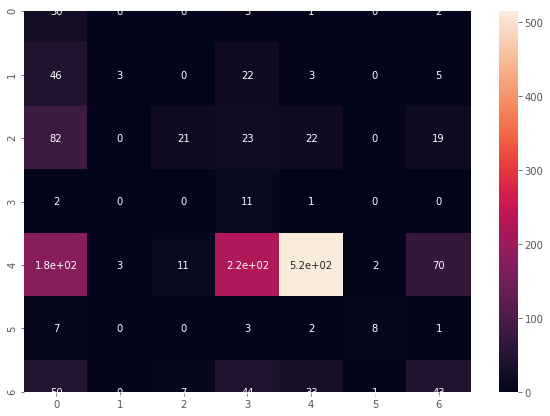

In [37]:
cm = confusion_matrix(y_true=np.argmax(y_val, axis=1), y_pred=classes , labels=NUMERIC_CLASSES)

df_cm = pd.DataFrame(cm, index=NUMERIC_CLASSES)
_ = plt.figure(figsize = (10,7))
_ = sn.heatmap(df_cm, annot=True)

# plt.savefig('imgs/ELM_confusion_matrix.png')

array([0, 0, 0, ..., 6, 6, 6])